Episode 1: Reward = -1.0
Episode 2: Reward = -1.0
Episode 3: Reward = -1.0
Episode 4: Reward = -1.0
Episode 5: Reward = -1.0
Episode 6: Reward = -1.0
Episode 7: Reward = -1.0
Episode 8: Reward = -1.0
Episode 9: Reward = 1.0
Episode 10: Reward = -1.0
Episode 11: Reward = 1.0
Episode 12: Reward = -1.0
Episode 13: Reward = -1.0
Episode 14: Reward = -1.0
Episode 15: Reward = -1.0
Episode 16: Reward = -1.0
Episode 17: Reward = -1.0
Episode 18: Reward = -1.0
Episode 19: Reward = 1.0
Episode 20: Reward = -1.0
Episode 21: Reward = 1.0
Episode 22: Reward = -1.0
Episode 23: Reward = 1.0
Episode 24: Reward = -1.0
Episode 25: Reward = -1.0
Episode 26: Reward = -1.0
Episode 27: Reward = -1.0
Episode 28: Reward = -1.0
Episode 29: Reward = -1.0
Episode 30: Reward = -1.0
Episode 31: Reward = -1.0
Episode 32: Reward = -1.0
Episode 33: Reward = 0.0
Episode 34: Reward = -1.0
Episode 35: Reward = -1.0
Episode 36: Reward = -1.0
Episode 37: Reward = -1.0
Episode 38: Reward = -1.0
Episode 39: Reward = 1.0
Ep

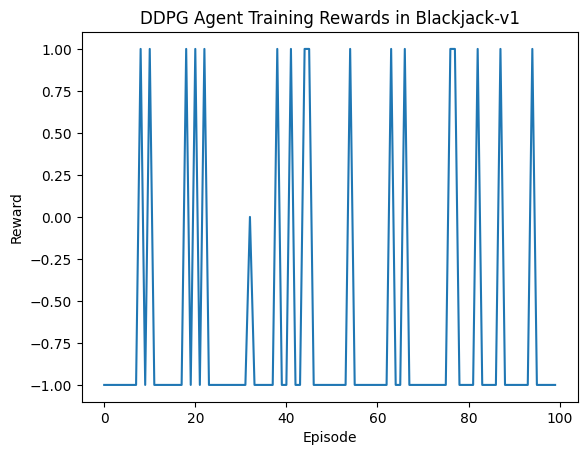

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# uyarı gizleme
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Actor ve Critic ağları
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)  # Ayrık aksiyon uzayına uygun hale getir
        return x


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        action = action.view(action.size(0), -1)  # action boyutunu uygun hale getir
        x = torch.relu(self.fc1(torch.cat([state, action], dim=1)))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# DDPG Agent
class DDPGAgent:
    def __init__(self, state_size, action_size, buffer_size=100000, batch_size=64, gamma=0.99, tau=0.001, lr_actor=1e-3, lr_critic=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size

        # Replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)

        # Actor ve Critic ağları
        self.actor = Actor(state_size, action_size)
        self.critic = Critic(state_size, action_size)
        self.target_actor = Actor(state_size, action_size)
        self.target_critic = Critic(state_size, action_size)

        # Hedef ağları başlat
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizer
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        # Keşif için epsilon-greedy yöntemi
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # Durumu uygun formata getir
        action_probs = self.actor(state).detach().numpy()[0]  # Aksiyonları al
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.action_size)  # Keşif
        else:
            action = np.argmax(action_probs)  # En iyi aksiyon
        return action

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Replay buffer'dan örnekler al
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)

        # Critic ağı eğit
        with torch.no_grad():
            next_action_probs = self.target_actor(next_states)
            next_actions = torch.argmax(next_action_probs, dim=1, keepdim=True)
            next_action_one_hot = torch.nn.functional.one_hot(next_actions, self.action_size).float()
            target_q_values = self.target_critic(next_states, next_action_one_hot)
            q_targets = rewards + self.gamma * (1 - dones) * target_q_values
        action_one_hot = torch.nn.functional.one_hot(actions, self.action_size).float()
        q_values = self.critic(states, action_one_hot)
        critic_loss = nn.MSELoss()(q_values, q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor ağı eğit
        action_probs = self.actor(states)
        chosen_actions = torch.argmax(action_probs, dim=1, keepdim=True)
        action_one_hot = torch.nn.functional.one_hot(chosen_actions, self.action_size).float()
        policy_loss = -self.critic(states, action_one_hot).mean()

        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        # Hedef ağları güncelle
        self.update_target_networks()

    def update_target_networks(self):
        for target_param, local_param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

        for target_param, local_param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)


# Eğitim fonksiyonu
def train_ddpg(agent, env, num_episodes=100):
    rewards_all_episodes = []

    for episode in range(num_episodes):
        state, _ = env.reset()  # Durumu al
        episode_reward = 0
        done = False

        max_steps = 200
        steps = 0

        while not done and steps < max_steps:
            action = agent.select_action(state)  # Ajanın aksiyonunu seç
            next_state, reward, done, _, _ = env.step(action)
            agent.replay_buffer.append((state, action, reward, next_state, done))
            agent.train()

            state = next_state
            episode_reward += reward
            steps += 1

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        rewards_all_episodes.append(episode_reward)
        print(f"Episode {episode+1}: Reward = {episode_reward}")

    return rewards_all_episodes


# Blackjack ortamını oluştur
env = gym.make("Blackjack-v1")
agent = DDPGAgent(state_size=3, action_size=2)  # Blackjack'te 2 aksiyon: hit ve stand

# Ajanı eğit
rewards = train_ddpg(agent, env, num_episodes=100)

# Sonuçları görselleştir
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DDPG Agent Training Rewards in Blackjack-v1')
plt.show()
